TODO: 
* 1. Check inner bias distribution
* 2. Plot weight distribution before/after quantization
* 3. Plot weight distribution before/after align limitation

### 1. Check inner bias / outer weight distribution

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from src.models import *
from src.model_analysis.visualize import layer_dist, act_dist, simulate_input, scale_plot, add_value_labels, get_linear_layers


org_model = resmlp_24(pretrained=True).eval()

In [4]:
model = resmlp_24(pretrained=True).eval()
m = get_linear_layers(model.blocks[0])
print([n for n,m in m])

['norm1', 'attn', 'gamma_1', 'norm2', 'mlp.fc1', 'mlp.fc2', 'gamma_2']


In [5]:
model = resmlp_24_v4(pretrained=True).eval()
m = get_linear_layers(model.blocks[0])
print([n for n,m in m])

['inner', 'outer', 'norm2', 'mlp.fc1', 'mlp.fc2', 'gamma_2']


In [2]:
def plot_layer(model, BLOCK, LAYER):
    name, layer = get_linear_layers(model.blocks[BLOCK])[LAYER]

    plt.rcParams["figure.figsize"] = [10, 6]
    plt.rcParams["figure.autolayout"] = True

    f, axes = plt.subplots(2, 2)
    weight = layer.weight
    bias = layer.bias

    # axes[0][0].set_title("bias", size=30)
    #ylabel("weight", size=30)
    # set_ylabel("weight", size=30)

    weight = weight.detach().numpy()
    x1 = weight.flatten()
    sns.heatmap(weight, center=0, cmap="PiYG", xticklabels=False, yticklabels=False, ax=axes[0][0])
    sns.histplot(x1, color="dodgerblue", kde=True,
        alpha=.4, edgecolor=(1, 1, 1), ax=axes[0][1])

    if bias is not None:
        bias = bias.detach().numpy().reshape(-1, 1)
        x2 = bias.flatten()
        if len(bias.shape) == 1:
            bias = bias.repeat(bias.shape[0], 1)
        
        sns.heatmap(bias, center=0, cmap="PiYG", xticklabels=False, yticklabels=False, ax=axes[1][0])
        sns.histplot(x2, color="dodgerblue", kde=True,
            alpha=.4, edgecolor=(1, 1, 1), ax=axes[1][1])


    axes[0][0].set_ylabel('Weight', size=16)
    axes[1][0].set_ylabel('Bias', size=16)

    axes[0][0].set_title("Heatmap", size=16)
    axes[0][1].set_title("Histplot", size=16)
    # save to folder
    _ = plt.savefig(f"reports/org_dist/layer_{BLOCK}_{LAYER}.png", dpi=300)


for i in range(24):
    for j in range(7):
        plot_layer(model, i, j)

NameError: name 'model' is not defined

In [37]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
def multipop(mylist, skip=[]):
    if len(skip) == 0:
        return mylist
    skip = sorted(skip)
    
    newlist = []
    skipcnt = -1
    for i, val in enumerate(mylist):
        skipcnt += 1
        if skipcnt >= len(skip):
            newlist.append(val)
            continue

        if i == skip[skipcnt]:
            continue
        else:
            newlist.append(val)
    return newlist


def draw_distribution_tensorboard(model, writer, skip=[]):
    cnt = 0
    for b_num in range(0,24):
        layers = get_linear_layers(model.blocks[b_num])
        layers = multipop(layers, skip=skip)
        for name, layer in layers:
            weight = layer.weight
            writer.add_histogram("weight", weight, cnt)

            bias = layer.bias
            if bias is not None:
                writer.add_histogram("bias", bias, cnt)

            cnt += 1

def compare_models(title, packs, skip=[]):
    for name, model in packs:
        print(f"runs/{title}/{name}")
        tb = SummaryWriter(f"runs/{title}/{name}")
        draw_distribution_tensorboard(model, tb, skip)

In [ ]:
# org: ['norm1', 'attn', 'gamma_1', 'norm2', 'mlp.fc1', 'mlp.fc2', 'gamma_2']
#  v4: ['inner', 'outer', 'norm2', 'mlp.fc1', 'mlp.fc2', 'gamma_2']

pack1 = ("org", resmlp_24(pretrained=True).eval())
pack2 = ("v4", resmlp_24_v4(pretrained=True).eval())
model3 = resmlp_24_v4(pretrained=False).eval()
model3.load_state_dict(torch.load('v3/folder_sgd2/checkpoint.pth', map_location='cpu')["model"])
pack3 = ("v4_l2", model3)

compare_models("no_inner", [pack2, pack3], [0])
compare_models("inner", [pack2, pack3], [1,2,3,4,5])
compare_models("dist", [pack1, pack2, pack3])

### 2. Sketch activation distribution (N times each layer)

In [44]:
from src.post_quant.utils import HookHandler
from src.data_utils import getTrainData, calibrate

def detach_act_func(org_val, output):
    if org_val is None:
        arr = []
    else:
        arr = org_val

    arr.append(output.cpu().detach().numpy())
    return arr

def draw_activation_tensorboard(title, model):
    all_layers = []
    for i in range(24):
        all_layers.append(get_linear_layers(model.blocks[i], prefix=f"{i}_"))

    activations = {}
    hook_handler = HookHandler()
    hook_handler.create_apply_hook(detach_act_func, activations, all_layers)

    print("Loading a small piece of training data...")
    data_loader = getTrainData(dataset='imagenet', path="E:\datasets\imagenet", batch_size=32, data_percentage=0.0001)
    print("Calibrating...")
    calibrate(data_loader, model)
    hook_handler.remove_hook()

    data = []
    labels = []
    for layer in all_layers:
        for n, m in layer:
            data.append(activations[n])
            labels.append(n)
    
    for name, layer in zip(labels, data):
        tb = SummaryWriter(f"runs/{title}/{name}")
        for i, act in enumerate(layer[0]):
            tb.add_histogram("activation", np.absolute(act), i)

draw_activation_tensorboard("act/org", resmlp_24(pretrained=True).eval())
draw_activation_tensorboard("act/v4", resmlp_24_v4(pretrained=True).eval())


Loading a small piece of training data...
Calibrating...
Calibrate: [0/4]	Time  7.897 ( 7.897)
Loading a small piece of training data...
Calibrating...
Calibrate: [0/4]	Time  7.673 ( 7.673)


#### Draw Quant Model's Weight/Activation Distribution

In [51]:
model = resmlp_24_v4(pretrained=True).eval()
qmodel = q_resmlp_v4(model)

In [52]:
print("Calibrating...") #to obtain scale
data_loader = getTrainData(dataset='imagenet', path="E:\datasets\imagenet", batch_size=32, data_percentage=0.001)
calibrate(data_loader, qmodel)

Calibrating...
Calibrate: [ 0/41]	Time  7.414 ( 7.414)
Calibrate: [10/41]	Time  0.105 ( 0.769)
Calibrate: [20/41]	Time  0.104 ( 0.453)
Calibrate: [30/41]	Time  0.106 ( 0.341)
Calibrate: [40/41]	Time  0.047 ( 0.282)


In [56]:
get_linear_layers(qmodel.blocks[0])[0]

AttributeError: 'QInner' object has no attribute 'in_features'

Text(0.5, 1.0, 'Histplot')

c:\Users\scott\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


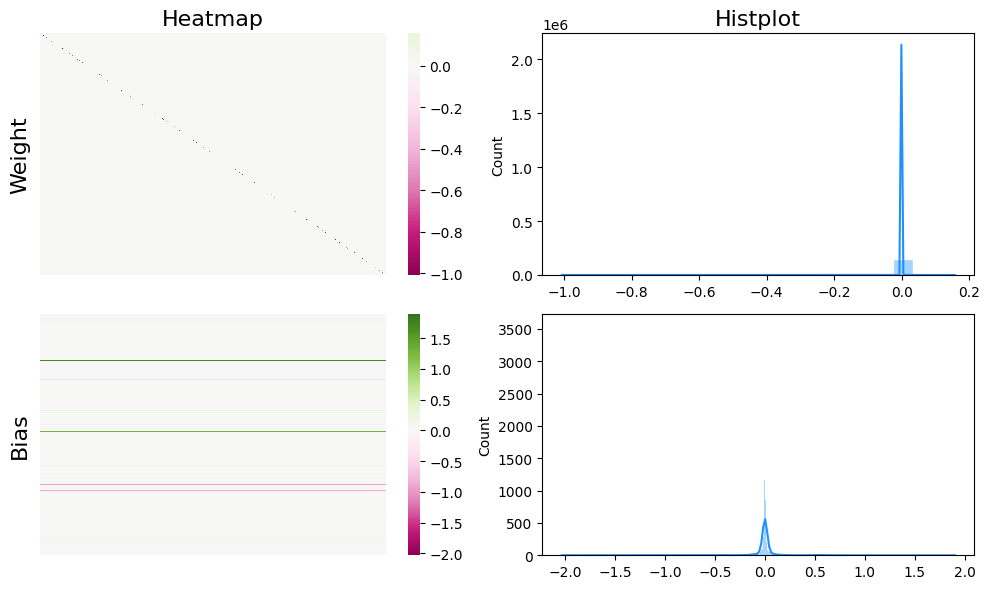

In [54]:
model.cpu()
name, layer = get_linear_layers(model.blocks[0])[0]

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

f, axes = plt.subplots(2, 2)
weight = layer.weight
bias = layer.bias

# axes[0][0].set_title("bias", size=30)
#ylabel("weight", size=30)
# set_ylabel("weight", size=30)

weight = weight.detach().numpy()
x1 = weight.flatten()
sns.heatmap(weight, center=0, cmap="PiYG", xticklabels=False, yticklabels=False, ax=axes[0][0])
sns.histplot(x1, color="dodgerblue", kde=True,
    alpha=.4, edgecolor=(1, 1, 1), ax=axes[0][1])

if bias is not None:
    bias = bias.detach().numpy().reshape(-1, 1)
    x2 = bias.flatten()
    if len(bias.shape) == 1:
        bias = bias.repeat(bias.shape[0], 1)
    
    sns.heatmap(bias, center=0, cmap="PiYG", xticklabels=False, yticklabels=False, ax=axes[1][0])
    sns.histplot(x2, color="dodgerblue", kde=True,
        alpha=.4, edgecolor=(1, 1, 1), ax=axes[1][1])


axes[0][0].set_ylabel('Weight', size=16)
axes[1][0].set_ylabel('Bias', size=16)

axes[0][0].set_title("Heatmap", size=16)
axes[0][1].set_title("Histplot", size=16)

### 3. Figure some method to fix alignment limitation

In [39]:
for name, layer in zip(labels, data):
    tb = SummaryWriter(f"runs/{title}/{name}")
    for i, act in enumerate(layer):
        print(act.shape, i)


(32, 196, 384) 0
(32, 196, 384) 1
(32, 196, 384) 2
(32, 196, 384) 3
(32, 196, 384) 0
(32, 196, 384) 1
(32, 196, 384) 2
(32, 196, 384) 3
(32, 196, 384) 0
(32, 196, 384) 1
(32, 196, 384) 2
(32, 196, 384) 3
(32, 196, 1536) 0
(32, 196, 1536) 1
(32, 196, 1536) 2
(32, 196, 1536) 3
(32, 196, 384) 0
(32, 196, 384) 1
(32, 196, 384) 2
(32, 196, 384) 3
(32, 196, 384) 0
(32, 196, 384) 1
(32, 196, 384) 2
(32, 196, 384) 3
(32, 196, 384) 0
(32, 196, 384) 1
(32, 196, 384) 2
(32, 196, 384) 3
(32, 196, 384) 0
(32, 196, 384) 1
(32, 196, 384) 2
(32, 196, 384) 3
(32, 196, 384) 0
(32, 196, 384) 1
(32, 196, 384) 2
(32, 196, 384) 3
(32, 196, 1536) 0
(32, 196, 1536) 1
(32, 196, 1536) 2
(32, 196, 1536) 3
(32, 196, 384) 0
(32, 196, 384) 1
(32, 196, 384) 2
(32, 196, 384) 3
(32, 196, 384) 0
(32, 196, 384) 1
(32, 196, 384) 2
(32, 196, 384) 3
(32, 196, 384) 0
(32, 196, 384) 1
(32, 196, 384) 2
(32, 196, 384) 3
(32, 196, 384) 0
(32, 196, 384) 1
(32, 196, 384) 2
(32, 196, 384) 3
(32, 196, 384) 0
(32, 196, 384) 1
(32, 1